
# Arrival delay vs swarm size (SR BO for retardant drops)



## Experiment design
- Evidence-based parameters (CFA slope rule, Tolhurst ROS scale, MAFFS-like retardant footprint, long half-life) with a single tuning cell.
- Visual sanity checks: ignition + baseline spread without suppression, search grid overlay.
- Heuristic gallery: 10 heuristic placements (2x5 grid) on a representative setting.
- BO diagnostics per setting: hyperparameters, learning curve, scenario outcome.
- Cross-setting assessment: phase diagrams/heatmaps + best-overall snapshot.



### Evidence-based parameter choices
The environment and suppression parameters are chosen to be consistent with publicly documented fire and retardant behaviour. Firstly, slope sensitivity follows the Victorian CFA rule-of-thumb that the local rate of spread $\mathrm{ROS}$ approximately doubles for each $10^\circ$ increase in upslope \cite{CFAFireBehaves}. Secondly, the baseline $\mathrm{ROS}$ is calibrated to extreme short-duration values reported in Victorian fire behaviour analyses (used here as a reference scale) \cite{Tolhurst2009}. For retardant, persistence is modelled using a long half-life $t_{1/2}$, meaning that retardant remains effective until significant rainfall \cite{PerimeterPhosChekFAQ}. Finally, the order of magnitude of the drop footprint $(w_d, h_d)$ follows MAFFS coverage dimensions (physical length $\approx 0.4~\mathrm{km}$ and width $\approx 0.02~\mathrm{km}$), mapped onto the discretised grid abstraction \cite{USAFMAFFS}.


In [77]:

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from sklearn.exceptions import ConvergenceWarning
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel

from fire_model.ca import FireEnv, CAFireModel
from fire_model.bo_sr import RetardantDropBayesOptSR, TiedSRDeltaMatern

# Suppress noisy optimisation warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*Optimal value found for.*")
warnings.filterwarnings("ignore", message=".*Predicted variances smaller than observation noise.*")


In [78]:
import warnings
warnings.filterwarnings("ignore", message=".*balance properties of Sobol.*")


In [ ]:

# Master configuration (tune everything here).
CONFIG = {
    "grid": {
        "size": (150, 150),
        "domain_km": 3.0,
        "dt_s": 5.0,
    },
    "fire": {
        "ros_mps": 0.1,  # steady-state ROS (Tolhurst 2009)
        "ros_accel_tau_s": 1200.0,  # time constant for ROS ramp-up from ignition (None/<=0 disables)
        "wind": (0.35, 0.10),
        "burn_time_s0": 600.0,
        "retardant_half_life_s": 7200.0,
        "retardant_k": 1.0,
        "retardant_cell_cap": 2.5,
        "wind_coeff": 0.55,
        "drop_w_km": 0.02,
        "drop_h_km": 0.40,
        "drop_amount": 1.0,
        "avoid_burning_drop": True,
    },
    "ignition": {
        "center_frac": (0.42, 0.45),
        "radius_km": 0.05,  # very small ignition
    },
    "sweep": {
        "time_of_arrival_s": [60.0, 300.0, 600.0, 900, 1200.0, 1500, 2100, 2400.0],
        "drone_counts": [2,4,6,8,10],
        "horizon_total_s": 3600.0,
        "horizon_s": 720.0,
        "n_mc": 10,
        "seed": 5,
    },
    "diagnostics": {
        "settings": [(60.0, 2), (300.0, 4)],  # per-run plots (toggle to taste)
        "horizon_total_s": 4800.0,
        "horizon_s": 720.0,
        "n_mc": 20,
    },
    "search_grid": {
        "fire_boundary_probability": 0.25,
        "K_grid": 180,
        "boundary_field": "affected",
        "n_r": 150,
        "smooth_iters": 200,
        "omega": 1.0,
    },
    "bo": {
        "n_init": 20,
        "n_iters": 80,
        "n_candidates": 2**12,
        "xi": 0.03,
        "use_ard_kernel": False,
        "candidate_strategy": "mixed",
        "candidate_qmc": "sobol",
        "candidate_local_frac": 0.6,
        "candidate_local_top_k": 6,
        "candidate_local_sigma_s": 0.03,
        "candidate_local_sigma_r": 0.03,
        "candidate_local_sigma_delta_rad": np.deg2rad(9.0),
        "candidate_local_resample_delta_prob": 0.05,
        "init_strategy": "heuristic",
        "init_heuristic_random_frac": 0.4,
        "init_heuristic_kwargs":  {"value_power": 2.4, "r_offset": -0.02, "jitter_delta_rad": np.deg2rad(8.0), "uniform_ring_jitter_s": 0.15, "uniform_ring_jiter_r": 0.05, "downwind_line_wind_bias": 3.0, "downwind_line_jitter_r": 0.2, "heuristic_mix_prob":0.3},
        "init_heuristic_value_prob": 0.0,
        "init_heuristic_uniform_ring_prob": 0.5,
        "init_heuristic_downwind_prob": 0.5,
    },
    "heuristics": {
        "n_evals": 20,
        "heuristic_random_frac": 0.4,
        "heuristic_kwargs": {"value_power": 2.4, "r_offset": -0.02, "jitter_delta_rad": np.deg2rad(8.0), "uniform_ring_jitter_s": 0.15, "uniform_ring_jiter_r": 0.05, "downwind_line_wind_bias": 3.0, "downwind_line_jitter_r": 0.2},
        "heuristic_value_prob": 0,
        "heuristic_uniform_ring_prob": 0.5,
        "heuristic_downwind_prob": 0.5,
        "heuristic_mix_prob": 0.3,
        "heuristic_mix_ratio": 0.5,
    },
    "plots": {
        "example_n_sims": 12,
        "heuristic_figsize": (14, 6),
        "bo_outcome_n_sims": 12,
    },
}


In [92]:
# Helper functions (build env, rollouts, BO wrapper, plotting helpers).

def sr_kwargs(cfg):
    sg = cfg.get("search_grid", {})
    return {
        "K": sg.get("K_grid", sg.get("K", 500)),
        "boundary_field": sg.get("boundary_field", "affected"),
        "n_r": sg.get("n_r", 160),
        "smooth_iters": sg.get("smooth_iters", 350),
        "omega": sg.get("omega", 1.0),
    }

def ignition_center_px(cfg):
    nx, ny = cfg["grid"]["size"]
    fx, fy = cfg["ignition"]["center_frac"]
    return (int(fx * nx), int(fy * ny))

def build_ros_schedule(cfg):
    base = cfg["fire"].get("ros_mps", 0.5)
    tau = cfg["fire"].get("ros_accel_tau_s", None)
    if tau is None or tau <= 0.0:
        return base
    dt = cfg["grid"]["dt_s"]
    arrivals = list(cfg["sweep"].get("time_of_arrival_s", []))
    arrivals.extend([a for a, _ in cfg.get("diagnostics", {}).get("settings", [])])
    max_arrival = max(arrivals) if arrivals else 0.0
    horizons = [cfg["sweep"].get("horizon_total_s", cfg["sweep"].get("horizon_s", 0.0)), cfg.get("diagnostics", {}).get("horizon_s", 0.0)]
    total_time = max_arrival + max(horizons)
    steps = int(np.ceil(total_time / dt)) + 1
    t = np.arange(steps) * dt
    accel = 1.0 - np.exp(-t / tau)
    return base * accel

def build_fire_model(cfg, seed: int = 0) -> CAFireModel:
    nx, ny = cfg["grid"]["size"]
    fuel = np.ones((nx, ny), dtype=float)
    value = np.ones_like(fuel)
    wind_field = np.zeros((nx, ny, 2), dtype=float)
    wind_field[..., 0] = cfg["fire"]["wind"][0]
    wind_field[..., 1] = cfg["fire"]["wind"][1]

    env = FireEnv(
        grid_size=(nx, ny),
        domain_km=cfg["grid"]["domain_km"],
        fuel=fuel,
        value=value,
        wind=wind_field,
        dt_s=cfg["grid"]["dt_s"],
        burn_time_s0=cfg["fire"]["burn_time_s0"],
        retardant_half_life_s=cfg["fire"]["retardant_half_life_s"],
        retardant_k=cfg["fire"]["retardant_k"],
        drop_w_km=cfg["fire"]["drop_w_km"],
        drop_h_km=cfg["fire"]["drop_h_km"],
        drop_amount=cfg["fire"]["drop_amount"],
        ros_mps=build_ros_schedule(cfg),
        wind_coeff=cfg["fire"]["wind_coeff"],
        diag=True,
        avoid_burning_drop=cfg["fire"]["avoid_burning_drop"],
        avoid_drop_p_threshold=0.25,
        retardant_cell_cap=cfg["fire"].get("retardant_cell_cap", None),
    )
    return CAFireModel(env, seed=seed)

def rollout_to_arrival(fire_model: CAFireModel, time_of_arrival_s: float, *, n_mc: int, seed: int) -> object:
    center = ignition_center_px(CONFIG)
    radius_km = CONFIG["ignition"]["radius_km"]
    init_batch = fire_model.init_state_batch(n_sims=n_mc, center=center, radius_km=radius_km)
    return fire_model.simulate_from_firestate(
        init_batch,
        T=time_of_arrival_s,
        n_sims=n_mc,
        drone_params=None,
        ros_mps=fire_model.env.ros_mps,
        wind_coeff=fire_model.env.wind_coeff,
        diag=True,
        seed=seed,
        avoid_burning_drop=CONFIG["fire"]["avoid_burning_drop"],
    )

def expected_burned_km2(fire_model: CAFireModel, firestate) -> float:
    p_burning = np.asarray(firestate.burning[0], dtype=float)
    p_burned = np.asarray(firestate.burned[0], dtype=float)
    p_aff = np.clip(p_burning + p_burned, 0.0, 1.0)
    dx = fire_model.env.domain_km / fire_model.env.grid_size[0]
    return float(np.sum(p_aff * fire_model.env.value) * (dx ** 2))

def make_bo_for_setting(time_of_arrival_s: float, n_drones: int, *, cfg=None, seed_offset: int = 0):
    cfg = CONFIG if cfg is None else cfg
    fm = build_fire_model(cfg, seed=cfg["sweep"]["seed"] + seed_offset)
    arrival_state = rollout_to_arrival(
        fm,
        time_of_arrival_s,
        n_mc=cfg["sweep"]["n_mc"],
        seed=cfg["sweep"]["seed"] + seed_offset,
    )
    total_horizon = cfg["sweep"].get("horizon_total_s", cfg["sweep"].get("horizon_s", 0.0))
    horizon_after = max(total_horizon - time_of_arrival_s, 0.0)
    bo = RetardantDropBayesOptSR(
        fire_model=fm,
        init_firestate=arrival_state,
        n_drones=int(n_drones),
        evolution_time_s=horizon_after,
        n_sims=cfg["sweep"]["n_mc"],
        fire_boundary_probability=cfg["search_grid"].get("fire_boundary_probability", 0.3),
        search_grid_evolution_time_s=cfg["search_grid"].get("evolution_time_s", horizon_after),
        rng=np.random.default_rng(cfg["sweep"]["seed"] + seed_offset + 2),
    )
    return bo, arrival_state

def eval_theta_fields(bo: RetardantDropBayesOptSR, theta, n_sims: int | None = None):
    params = bo.decode_theta(theta)
    evolved = bo._simulate_firestate_with_params(params, n_sims=n_sims)
    p_aff = np.clip(evolved.burning[0] + evolved.burned[0], 0.0, 1.0)
    obj = bo._expected_value_from_firestate(evolved)
    r = None
    if hasattr(evolved, "retardant") and evolved.retardant is not None:
        R = np.asarray(evolved.retardant, float)
        if R.ndim == 3:
            R = R.mean(axis=0)
        r = np.maximum(R, 0.0)
    return obj, p_aff, evolved, r

def fit_gp_from_history(history, *, use_ard: bool = False):
    X, y = history
    if use_ard:
        base_kernel = Matern(length_scale=np.ones(X.shape[1], dtype=float), nu=2.5, length_scale_bounds=(1e-3, 1e3))
    else:
        base_kernel = TiedSRDeltaMatern(ls=0.2, lr=0.2, ldelta=0.5, nu=2.5, length_scale_bounds=(1e-3, 1e3))
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * base_kernel + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=2, random_state=None)
    gp.fit(X, y)
    return gp

def plot_learning_curve(y_bests, title: str = "BO learning curve"):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(range(1, len(y_bests) + 1), y_bests, marker="o")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Best-so-far objective (km$^2$)")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_phase_diagram(df, *, title: str):
    pivot = df.pivot(index="n_drones", columns="time_of_arrival_s", values="relative_reduction") * 100.0
    fig, ax = plt.subplots(figsize=(8, 4.5))
    im = ax.imshow(pivot.values, origin="lower", aspect="auto", cmap="viridis")
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{c/60:.1f}" for c in pivot.columns])
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel("Time of arrival (minutes)")
    ax.set_ylabel("Number of drones")
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label="Reduction vs. baseline (%)")
    plt.tight_layout()
    plt.show()


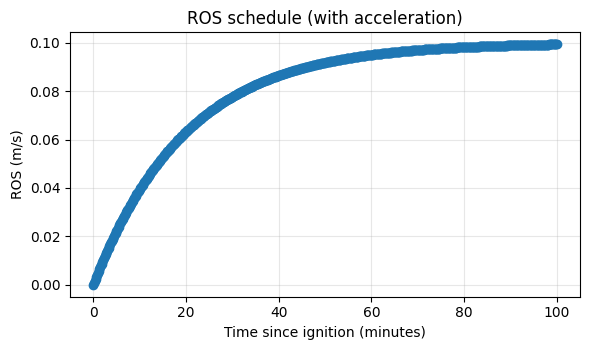

In [93]:

# ROS schedule vs time (includes acceleration from ignition if enabled).
ros_sched = np.asarray(build_ros_schedule(CONFIG), dtype=float)
if ros_sched.ndim == 0:
    ros_sched = ros_sched[None]
t_ros = np.arange(ros_sched.shape[0]) * CONFIG["grid"]["dt_s"] / 60.0
plt.figure(figsize=(6.0, 3.6))
plt.plot(t_ros, ros_sched, marker="o", linewidth=1.4)
plt.xlabel("Time since ignition (minutes)")
plt.ylabel("ROS (m/s)")
plt.title("ROS schedule (with acceleration)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params


/var/folders/fr/0hknr11j3dx6vtmvs5kk3gvh0000gn/T/ipykernel_19378/695146626.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


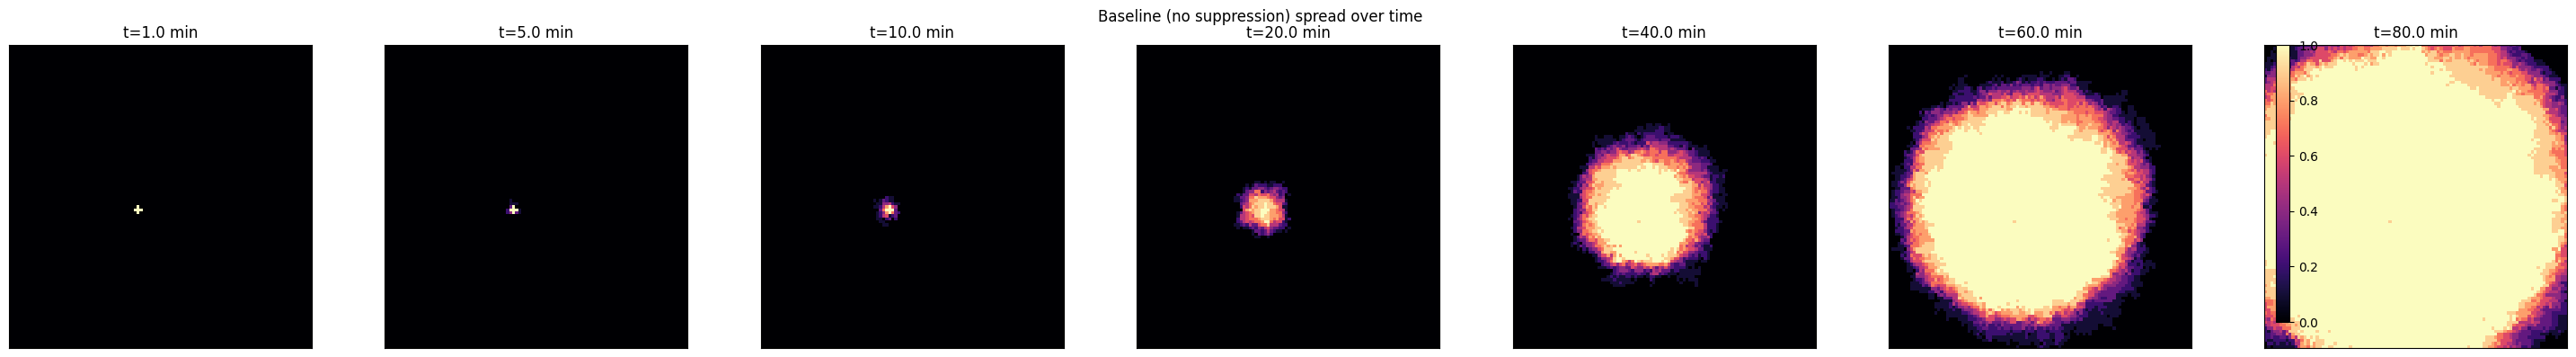

In [89]:

# Baseline fire growth over time (no suppression) to visualise acceleration.
cfg = CONFIG
fm = build_fire_model(cfg, seed=cfg["sweep"]["seed"] + 123)
center = ignition_center_px(cfg)
radius = cfg["ignition"]["radius_km"]
init_batch = fm.init_state_batch(n_sims=cfg["sweep"]["n_mc"], center=center, radius_km=radius)

snap_times = [60.0, 300.0, 600.0,1200,2400,3600,4800]  # seconds
fire_norm = mcolors.PowerNorm(gamma=0.65, vmin=0.0, vmax=1.0)
fire_interp = "bicubic"
fig, axes = plt.subplots(1, len(snap_times), figsize=(4.2 * len(snap_times), 4.0))
axes = np.atleast_1d(axes)
for ax, T in zip(axes, snap_times):
    state = fm.simulate_from_firestate(
        init_batch,
        T=T,
        n_sims=cfg["sweep"]["n_mc"],
        drone_params=None,
        ros_mps=fm.env.ros_mps,
        wind_coeff=fm.env.wind_coeff,
        diag=True,
        seed=cfg["sweep"]["seed"] + int(T),
        avoid_burning_drop=cfg["fire"]["avoid_burning_drop"],
    )
    p_aff = np.clip(state.burning[0] + state.burned[0], 0.0, 1.0)
    im = ax.imshow(p_aff.T, origin="lower", norm=fire_norm, cmap="inferno", interpolation=fire_interp)
    ax.set_title(f"t={T/60:.1f} min")
    ax.set_xticks([]); ax.set_yticks([])
fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02)
plt.suptitle("Baseline (no suppression) spread over time")
plt.tight_layout()
plt.show()


In [94]:

# Define the grid to explore (detection delay x drone count).
sweep_delays = CONFIG["sweep"]["time_of_arrival_s"]
sweep_drones = CONFIG["sweep"]["drone_counts"]
SWEEP_GRID = [(d, n) for d in sweep_delays for n in sweep_drones]
print(f"Total combinations: {len(SWEEP_GRID)}")
print("Examples:", SWEEP_GRID[: min(6, len(SWEEP_GRID))])


Total combinations: 20
Examples: [(300.0, 2), (300.0, 4), (300.0, 6), (300.0, 8), (300.0, 10), (600.0, 2)]


No drone_params
No drone_params


/var/folders/fr/0hknr11j3dx6vtmvs5kk3gvh0000gn/T/ipykernel_19378/2796475804.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


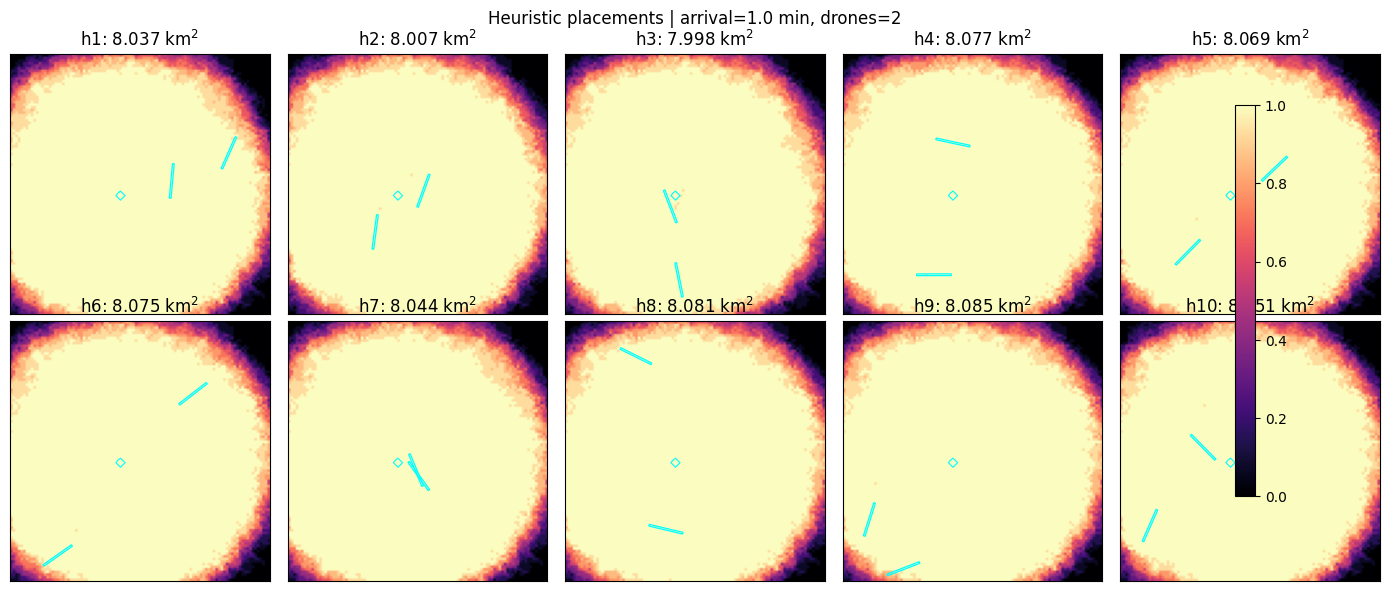

In [84]:

# Heuristic gallery: 10 heuristic placements (2x5 grid) for a representative setting.
heur_setting = CONFIG["diagnostics"]["settings"][0]
heur_delay, heur_nd = heur_setting
bo_h, detected_h = make_bo_for_setting(heur_delay, heur_nd, seed_offset=11)
bo_h.setup_search_grid_sr(**sr_kwargs(CONFIG))

p_detect = np.clip(detected_h.burning[0] + detected_h.burned[0], 0.0, 1.0)

# Sample heuristics
thetas = bo_h.sample_initial_thetas(
    n_init=CONFIG["heuristics"]["n_evals"],
    strategy="heuristic",
    heuristic_random_frac=CONFIG["heuristics"].get("heuristic_random_frac", 0.0),
    heuristic_kwargs=CONFIG["heuristics"].get("heuristic_kwargs", {}),
    heuristic_value_prob=CONFIG["heuristics"].get("heuristic_value_prob", 0.5),
    heuristic_uniform_ring_prob=CONFIG["heuristics"].get("heuristic_uniform_ring_prob", 0.25),
    heuristic_downwind_prob=CONFIG["heuristics"].get("heuristic_downwind_prob", 0.25),
    heuristic_mix_prob=CONFIG["heuristics"].get("heuristic_mix_prob", 0.15),
    heuristic_mix_ratio=CONFIG["heuristics"].get("heuristic_mix_ratio", 0.5),
)

dx = bo_h.fire_model.dx
w_cells = CONFIG["fire"]["drop_w_km"] / dx
h_cells = CONFIG["fire"]["drop_h_km"] / dx

fire_norm = mcolors.PowerNorm(gamma=0.65, vmin=0.0, vmax=1.0)
fire_interp = "bicubic"
fig, axes = plt.subplots(2, 5, figsize=CONFIG["plots"]["heuristic_figsize"])
axes = axes.ravel()
legend_handles = []
for idx, (ax, theta) in enumerate(zip(axes, np.atleast_2d(thetas))):
    obj, p_aff, evolved, r_map = eval_theta_fields(bo_h, theta)
    im = ax.imshow(p_aff.T, origin="lower", norm=fire_norm, cmap="inferno", interpolation=fire_interp)
    # Outline detected fire
    cs = ax.contour(p_detect.T, levels=[0.25], colors='cyan', linewidths=0.8)
    colls = getattr(cs, 'collections', None)
    if colls:
        colls[0].set_label('detected fire')
        if colls[0] not in legend_handles:
            legend_handles.append(colls[0])
    # Drone rectangles
    if r_map is not None:
        r_max = float(np.max(r_map)) if r_map.size else 0.0
        if r_max > 0.0:
            alpha = np.clip(r_map / r_max, 0.0, 1.0).T * 0.45
            ax.imshow(r_map.T, origin="lower", cmap="magma", interpolation="nearest", alpha=alpha)
    params = bo_h.decode_theta(theta)
    for j, (x0, y0, phi) in enumerate(params):
        rect = mpatches.Rectangle(
            (x0 - 0.5 * w_cells, y0 - 0.5 * h_cells),
            width=w_cells,
            height=h_cells,
            angle=np.degrees(phi),
            fill=False,
            edgecolor='cyan',
            linewidth=0.9,
        )
        ax.add_patch(rect)
        if rect not in legend_handles:
            #rect.set_label('drone drop footprint')
            legend_handles.append(rect)
    ax.set_title(f"h{idx+1}: {obj:.3f} km$^2$")
    ax.set_xticks([]); ax.set_yticks([])

#if legend_handles:
    #fig.legend(handles=legend_handles, loc='upper center', ncol=len(legend_handles))
fig.suptitle(f"Heuristic placements | arrival={heur_delay/60:.1f} min, drones={heur_nd}")
fig.colorbar(im, ax=axes.tolist(), fraction=0.018)
plt.tight_layout()
plt.show()


=== BO diagnostic: arrival=1.0 min | drones=2 ===
No drone_params
No drone_params
GP kernel_: 0.946**2 * TiedSRDeltaMatern(ls=0.507, lr=0.907, ldelta=6.63, nu=2.5) + WhiteKernel(noise_level=0.171)


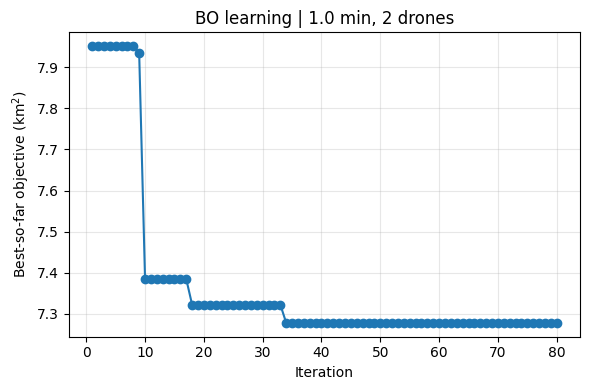

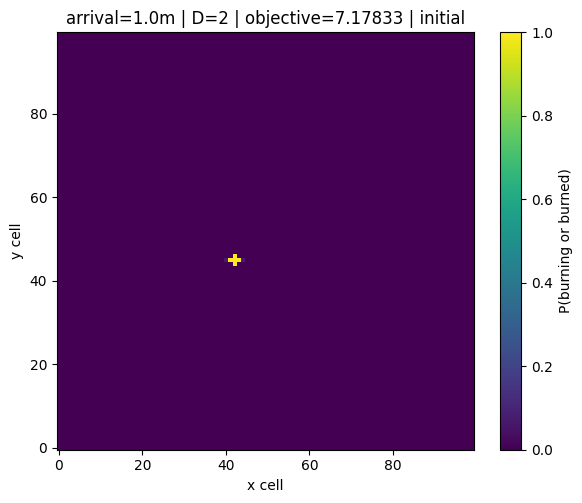

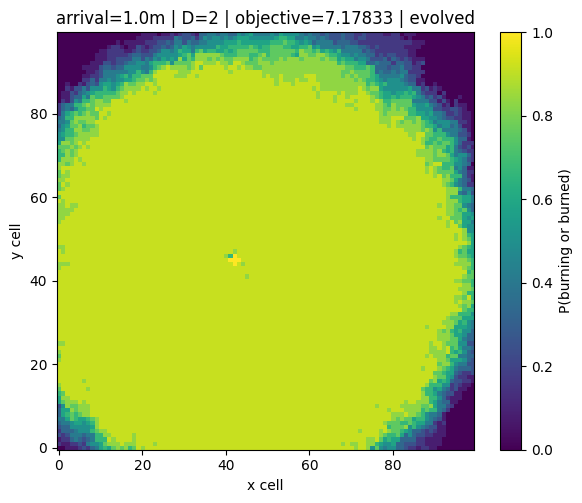

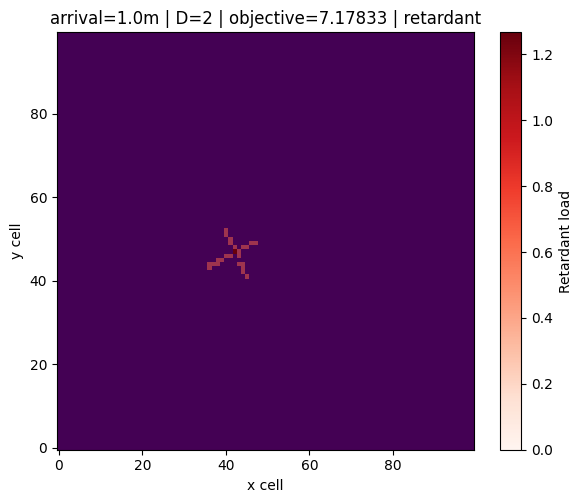

=== BO diagnostic: arrival=5.0 min | drones=4 ===
No drone_params
No drone_params
GP kernel_: 0.846**2 * TiedSRDeltaMatern(ls=1e+03, lr=0.77, ldelta=11.6, nu=2.5) + WhiteKernel(noise_level=0.301)


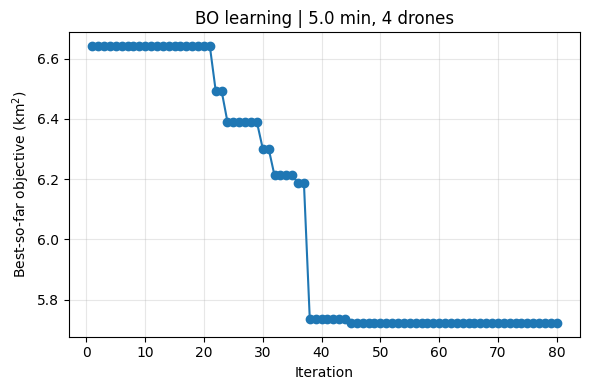

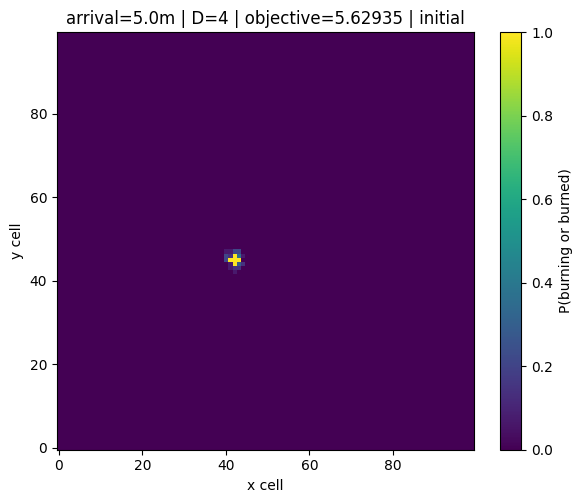

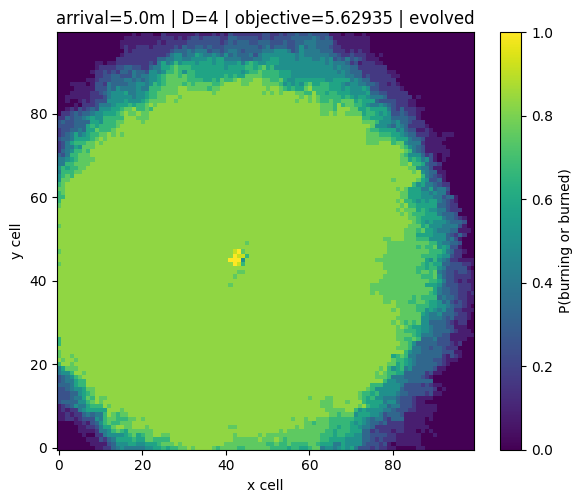

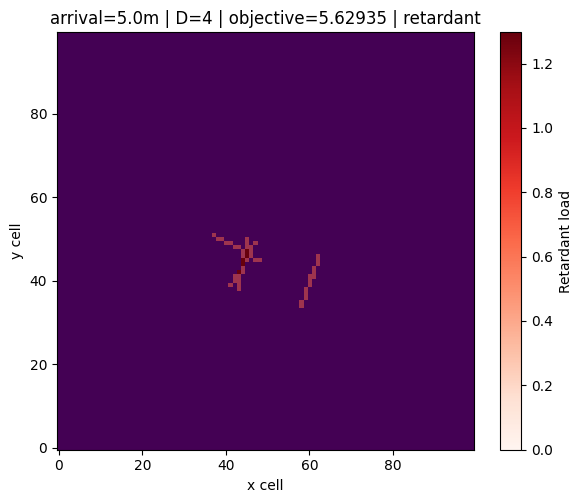

,time_of_arrival_s,n_drones,best_burned_area,baseline_area,relative_reduction,kernel
0,60.0,2,7.278043,0.004629,NaN,"0.946**2 * TiedSRDeltaMatern(ls=0.507, lr=0.90..."
1,300.0,4,5.722650,0.006750,NaN,"0.846**2 * TiedSRDeltaMatern(ls=1e+03, lr=0.77..."


In [85]:

# BO diagnostics per selected settings (hyperparameters, learning curve, scenario outcome).
diag_settings = CONFIG["diagnostics"]["settings"]
records_diag = []
for (arrival_s, n_drones) in diag_settings:
    print(f"=== BO diagnostic: arrival={arrival_s/60:.1f} min | drones={n_drones} ===")
    bo, arrival_state = make_bo_for_setting(arrival_s, n_drones, seed_offset=int(arrival_s + n_drones))
    bo.setup_search_grid_sr(**sr_kwargs(CONFIG))

    best_theta, best_params, best_y, history, y_nexts, y_bests = bo.run_bayes_opt(
        n_init=CONFIG["bo"]["n_init"],
        n_iters=CONFIG["bo"]["n_iters"],
        n_candidates=CONFIG["bo"]["n_candidates"],
        xi=CONFIG["bo"]["xi"],
        verbose=False,
        print_every=0,
        use_ard_kernel=CONFIG["bo"].get("use_ard_kernel", False),
        init_strategy=CONFIG["bo"]["init_strategy"],
        init_heuristic_random_frac=CONFIG["bo"]["init_heuristic_random_frac"],
        init_heuristic_kwargs=CONFIG["bo"]["init_heuristic_kwargs"],
        init_heuristic_value_prob=CONFIG["bo"]["init_heuristic_value_prob"],
        init_heuristic_uniform_ring_prob=CONFIG["bo"]["init_heuristic_uniform_ring_prob"],
        init_heuristic_downwind_prob=CONFIG["bo"]["init_heuristic_downwind_prob"],
        candidate_strategy=CONFIG["bo"]["candidate_strategy"],
        candidate_qmc=CONFIG["bo"].get("candidate_qmc", "sobol"),
        candidate_local_frac=CONFIG["bo"]["candidate_local_frac"],
        candidate_local_top_k=CONFIG["bo"]["candidate_local_top_k"],
        candidate_local_sigma_s=CONFIG["bo"]["candidate_local_sigma_s"],
        candidate_local_sigma_r=CONFIG["bo"]["candidate_local_sigma_r"],
        candidate_local_sigma_delta_rad=CONFIG["bo"]["candidate_local_sigma_delta_rad"],
        candidate_local_resample_delta_prob=CONFIG["bo"]["candidate_local_resample_delta_prob"],
        K_grid=CONFIG["search_grid"]["K_grid"],
        boundary_field=CONFIG["search_grid"]["boundary_field"],
        n_r=CONFIG["search_grid"]["n_r"],
        smooth_iters=CONFIG["search_grid"]["smooth_iters"],
        omega=CONFIG["search_grid"]["omega"],
        eval_seed=CONFIG["sweep"]["seed"] + 12345,
    )

    gp = fit_gp_from_history(history, use_ard=CONFIG["bo"].get("use_ard_kernel", False))
    print("GP kernel_:", gp.kernel_)

    plot_learning_curve(y_bests, title=f"BO learning | {arrival_s/60:.1f} min, {n_drones} drones")
    bo.plot_evolved_firestate(best_theta, n_sims=CONFIG["plots"]["bo_outcome_n_sims"], title_prefix=f"arrival={arrival_s/60:.1f}m | D={n_drones}")

    records_diag.append(
        {
            "time_of_arrival_s": arrival_s,
            "n_drones": n_drones,
            "best_burned_area": best_y,
            "baseline_area": expected_burned_km2(bo.fire_model, bo.init_firestate),
            "relative_reduction": np.nan,
            "kernel": str(gp.kernel_),
        }
    )

diag_df = pd.DataFrame(records_diag)
diag_df



In [ ]:

# Full sweep across grid; aggregate results and phase diagrams.
records = []
for arrival_s, n_drones in SWEEP_GRID:
    bo, arrival_state = make_bo_for_setting(arrival_s, n_drones, seed_offset=int(arrival_s + n_drones + 99))
    best_theta, best_params, best_y, history, y_nexts, y_bests = bo.run_bayes_opt(
        n_init=CONFIG["bo"]["n_init"],
        n_iters=CONFIG["bo"]["n_iters"],
        n_candidates=CONFIG["bo"]["n_candidates"],
        xi=CONFIG["bo"]["xi"],
        verbose=False,
        print_every=0,
        use_ard_kernel=CONFIG["bo"].get("use_ard_kernel", False),
        init_strategy=CONFIG["bo"]["init_strategy"],
        init_heuristic_random_frac=CONFIG["bo"]["init_heuristic_random_frac"],
        init_heuristic_kwargs=CONFIG["bo"]["init_heuristic_kwargs"],
        init_heuristic_value_prob=CONFIG["bo"]["init_heuristic_value_prob"],
        init_heuristic_uniform_ring_prob=CONFIG["bo"]["init_heuristic_uniform_ring_prob"],
        init_heuristic_downwind_prob=CONFIG["bo"]["init_heuristic_downwind_prob"],
        candidate_strategy=CONFIG["bo"]["candidate_strategy"],
        candidate_qmc=CONFIG["bo"].get("candidate_qmc", "sobol"),
        candidate_local_frac=CONFIG["bo"]["candidate_local_frac"],
        candidate_local_top_k=CONFIG["bo"]["candidate_local_top_k"],
        candidate_local_sigma_s=CONFIG["bo"]["candidate_local_sigma_s"],
        candidate_local_sigma_r=CONFIG["bo"]["candidate_local_sigma_r"],
        candidate_local_sigma_delta_rad=CONFIG["bo"]["candidate_local_sigma_delta_rad"],
        candidate_local_resample_delta_prob=CONFIG["bo"]["candidate_local_resample_delta_prob"],
        K_grid=CONFIG["search_grid"]["K_grid"],
        boundary_field=CONFIG["search_grid"]["boundary_field"],
        n_r=CONFIG["search_grid"]["n_r"],
        smooth_iters=CONFIG["search_grid"]["smooth_iters"],
        omega=CONFIG["search_grid"]["omega"],
        eval_seed=CONFIG["sweep"]["seed"] + 12345,
    )

    baseline = bo.fire_model.simulate_from_firestate(
        bo.init_firestate,
        T=bo.evolution_time_s,
        n_sims=cfg["sweep"]["n_mc"],
        drone_params=None,
        ros_mps=bo.fire_model.env.ros_mps,
        wind_coeff=bo.fire_model.env.wind_coeff,
        diag=bo.fire_model.env.diag,
        seed=cfg["sweep"]["seed"] + 12345,
    )
    baseline_area = expected_burned_km2(bo.fire_model, baseline)
    rel_red = 1.0 - float(best_y) / baseline_area

    records.append(
        {
            "time_of_arrival_s": arrival_s,
            "n_drones": n_drones,
            "baseline_area": baseline_area,
            "best_burned_area": float(best_y),
            "relative_reduction": rel_red,
            "best_trace": y_bests,
            "best_theta": best_theta,
        }
    )

results_df = pd.DataFrame(records).sort_values(["time_of_arrival_s", "n_drones"]).reset_index(drop=True)
results_df



No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params


,time_of_arrival_s,n_drones,baseline_area,best_burned_area,relative_reduction,best_trace,best_theta
0,300.0,2,0.00765,2.43342,-317.094118,"[2.66175, 2.66175, 2.66175, 2.66175, 2.66175, ...","[0.5995514018679198, 0.009451381178272752, 0.0..."
1,300.0,4,0.00756,2.29905,-303.107143,"[2.5848, 2.5848, 2.5848, 2.5848, 2.5848, 2.584...","[0.809584997532222, 0.0, 0.642149351717564, 0...."
2,300.0,6,0.00774,2.31480,-298.069767,"[2.3148, 2.3148, 2.3148, 2.3148, 2.3148, 2.314...","[0.7124001899951125, 0.030972143465046835, 0.0..."
3,300.0,8,0.00720,1.33875,-184.937500,"[2.6400599999999996, 2.6400599999999996, 2.640...","[0.08207278081849395, 0.0, 0.5516672443913337,..."
4,300.0,10,0.00720,1.43397,-198.162500,"[2.43198, 2.43198, 2.42649, 2.42649, 2.36871, ...","[0.47742275651560173, 0.0, 0.8761598084452649,..."
5,600.0,2,0.01710,2.65257,-154.121053,"[2.77317, 2.77317, 2.77317, 2.77317, 2.77317, ...","[0.8559553999852239, 0.07190475670515806, 0.96..."
6,600.0,4,0.01800,2.63619,-145.455000,"[2.71944, 2.71944, 2.71944, 2.71467, 2.65059, ...","[0.05701666799681414, 0.1665641545709732, 0.03..."
7,600.0,6,0.01809,2.61702,-143.666667,"[2.7882899999999995, 2.7882899999999995, 2.788...","[0.07934739261045674, 0.03755101459371618, 0.0..."
8,600.0,8,0.01899,2.27529,-118.815166,"[2.27529, 2.27529, 2.27529, 2.27529, 2.27529, ...","[0.7155423483844652, 0.08286457807208042, 0.0,..."
9,600.0,10,0.01881,2.40732,-126.980861,"[2.43072, 2.43072, 2.43072, 2.40732, 2.40732, ...","[0.8809870766298746, 0.06677558674933627, 0.98..."


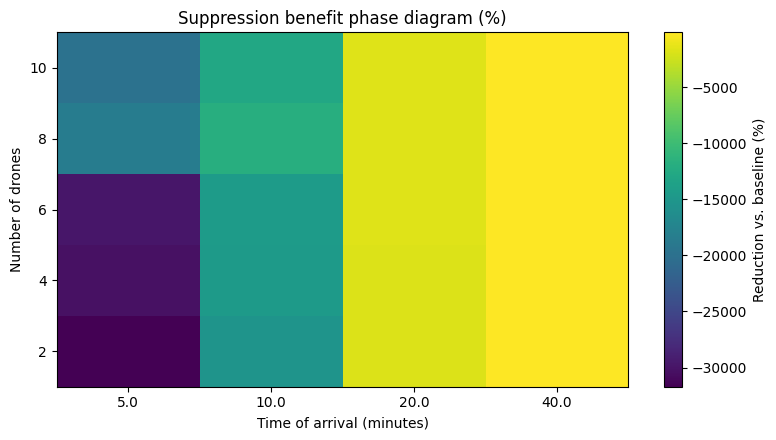

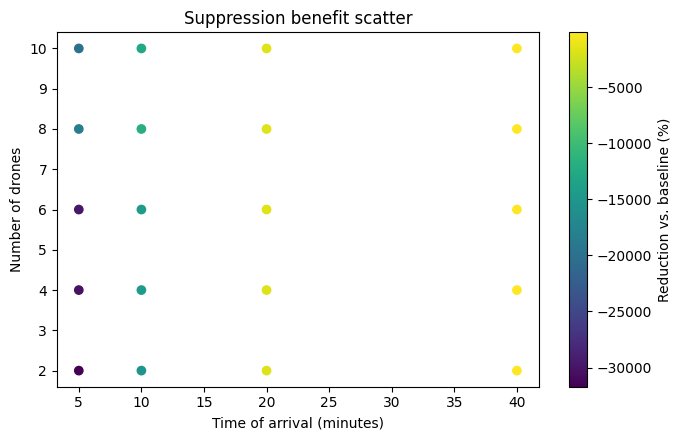

Best overall setting:
time_of_arrival_s       2400.0
n_drones                    10
best_burned_area       2.70171
baseline_area          1.32912
relative_reduction   -1.032706
Name: 19, dtype: object


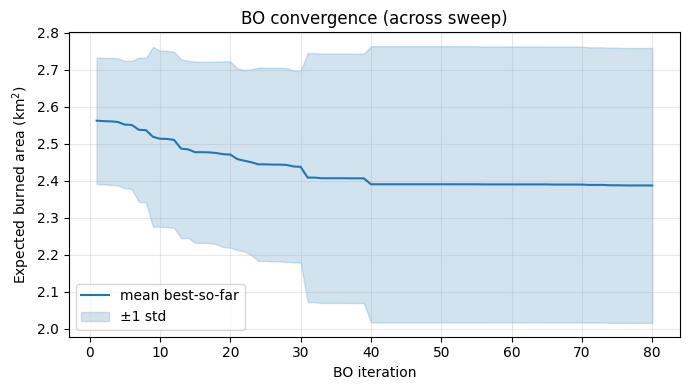

In [96]:

# Cross-setting visualisation: phase diagram, best overall, and learning stats.
plot_phase_diagram(results_df, title="Suppression benefit phase diagram (%)")

# Scatter of reductions
fig, ax = plt.subplots(figsize=(7, 4.5))
sc = ax.scatter(results_df["time_of_arrival_s"] / 60.0, results_df["n_drones"], c=results_df["relative_reduction"] * 100.0, cmap="viridis")
ax.set_xlabel("Time of arrival (minutes)")
ax.set_ylabel("Number of drones")
ax.set_title("Suppression benefit scatter")
fig.colorbar(sc, ax=ax, label="Reduction vs. baseline (%)")
plt.tight_layout()
plt.show()

# Best overall
best_idx = results_df["relative_reduction"].idxmax()
best_row = results_df.loc[best_idx]
print("Best overall setting:")
print(best_row[["time_of_arrival_s", "n_drones", "best_burned_area", "baseline_area", "relative_reduction"]])

# Learning curve statistics
max_len = max(len(t) for t in results_df["best_trace"])
mat = np.full((len(results_df), max_len), np.nan)
for i, trace in enumerate(results_df["best_trace"]):
    mat[i, : len(trace)] = trace
mean_trace = np.nanmean(mat, axis=0)
std_trace = np.nanstd(mat, axis=0)
fig2, ax2 = plt.subplots(figsize=(7, 4))
ax2.plot(range(1, len(mean_trace) + 1), mean_trace, label="mean best-so-far")
ax2.fill_between(range(1, len(mean_trace) + 1), mean_trace - std_trace, mean_trace + std_trace, color="tab:blue", alpha=0.2, label="±1 std")
ax2.set_xlabel("BO iteration")
ax2.set_ylabel("Expected burned area (km$^2$)")
ax2.set_title("BO convergence (across sweep)")
ax2.grid(alpha=0.3)
ax2.legend()
plt.tight_layout()
plt.show()



### Notes and extensions
- All parameters live in the CONFIG cell; adjust there to explore other grids, horizons, or BO/heuristic settings.
- Increase `diagnostics.settings` to get per-run plots for more cases (beware runtime). Reduce `n_iters`/`n_candidates`/`n_mc` if you need faster sweeps.
- To focus on heavier/lighter fires while keeping evidence alignment, adjust `fire.ros_mps` and `fire.wind_coeff` together.
